## SemEval_2019：Offensive language detection  based on Weka and Python 

In [1]:
# basic packages in python
import copy
import re
import os
import csv
import string
import nltk
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
# packages to build traditional machine learning classifiers 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from gensim.models import Word2Vec,FastText
# packages to build deep learning models
import keras
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam,SGD
from keras.preprocessing.sequence import pad_sequences
from keras import utils
from keras.models import Model
from keras import Sequential
from keras.layers import Conv1D,GRU,LSTM
from keras.layers import Dropout,MaxPooling1D,Concatenate,Dense,GlobalMaxPooling1D,GlobalAveragePooling1D,Input,Bidirectional,concatenate, SpatialDropout1D, Reshape, merge
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
from keras.utils import np_utils

### 1 load Data (OLID)

In [2]:
# To show the whole tweets
pd.set_option('max_colwidth',1000)
# If you want run, you need to download the dataset and change your own directory
train_directory = "C:/Users/93585/Desktop/MSC_project/report/DATASET/OLID/olid-training-v1.0.tsv"
data = pd.read_csv(train_directory, sep='\t', header=0)
data

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans what their take on this is.,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of shit to a volcano. 😂""",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illegals to move into red states,NOT,NaN,NaN
...,...,...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people and this man’s vibe is tens of millions of murders - he is more dangerous than DT.,OFF,TIN,IND
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too shabby of a summer,NOT,NaN,NaN
13237,82921,@USER And why report this garbage. We don't give a crap.,OFF,TIN,OTH
13238,27429,@USER Pussy,OFF,UNT,NaN


### 2 Data pre-processing

### 2.1 Data pre-processing in python

#### 2.1.1 basic data pre-processing

In [3]:
#1. clean data
def clean_data(sentence):
    # convert capital characters 
    sentence = sentence.lower()
    # solve situation like it's can't 're  've
    sentence = sentence.replace("it's","it is")
    sentence = sentence.replace("can't","can not")
    sentence = sentence.replace("’re"," are ")
    sentence = sentence.replace("'ve"," have ")
    # remove numbers
    sentence= re.sub(r'(\d)', ' ', sentence)
    # remove punctutaions
    punctuation = r'@#$%&*()_+{}|\[\]\:";\-\\\=\'<>!?,./'
    sentence = re.sub(r'[{}]+'.format(punctuation), ' ',sentence)
    # remove emotional symbol 
    sentence = re.sub(r'[^a-zA-Z]', ' ', sentence)
    # remove some nosies like  @USER or URL
    sentence = sentence.replace("user"," ").replace("url"," ")
    # just keep one space between each word and prepare for the tokenize
    sentence = ' '.join(sentence.split())
    
    return sentence

In [4]:
def updat_data(data):
    UPDATE_DATA = []
    for i, row in data.iterrows():
        #cled_sen = clean_data(row['tweet'])
        cled_sen = clean_data(row['tweet'])
        UPDATE_DATA.append(cled_sen)
    return UPDATE_DATA

#### 2.1.2 remove stop words

In [5]:
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))
def remove_stopwords(update_data):
    UPDATE_DATAA= []
    for i in update_data:
        Q = i.split(' ')
        H = []
        for t in Q:
            if t not in stopWords:
                H.append(t)
        Z = " ".join(H)
        UPDATE_DATAA.append(Z)
    
    return UPDATE_DATAA

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\93585\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
update_Data = updat_data(data)
remove_data = remove_stopwords(update_Data)
data.insert(loc=2, column='cleaned_tweets', value=remove_data)
data = data.drop(['tweet'],axis = 1)
data

,id,cleaned_tweets,subtask_a,subtask_b,subtask_c
0,86426,ask native americans take,OFF,UNT,NaN
1,90194,go home drunk maga trump,OFF,TIN,IND
2,16820,amazon investigating chinese employees selling internal data third party sellers looking edge competitive marketplace amazon maga kag china tcot,NOT,NaN,NaN
3,62688,someone taken piece shit volcano,OFF,UNT,NaN
4,43605,obama wanted liberals amp illegals move red states,NOT,NaN,NaN
...,...,...,...,...,...
13235,95338,sometimes get strong vibes people man vibe tens millions murders dangerous dt,OFF,TIN,IND
13236,67210,benidorm creamfields maga shabby summer,NOT,NaN,NaN
13237,82921,report garbage give crap,OFF,TIN,OTH
13238,27429,pussy,OFF,UNT,NaN


#### 2.1.3 remove missing words

In [7]:
#missing words
INDEX = []
for i, row in data.iterrows():
    if(row['cleaned_tweets'] == None or row['cleaned_tweets']==''):
        INDEX.append(i)
data.drop(INDEX,inplace = True)

In [8]:
data

,id,cleaned_tweets,subtask_a,subtask_b,subtask_c
0,86426,ask native americans take,OFF,UNT,NaN
1,90194,go home drunk maga trump,OFF,TIN,IND
2,16820,amazon investigating chinese employees selling internal data third party sellers looking edge competitive marketplace amazon maga kag china tcot,NOT,NaN,NaN
3,62688,someone taken piece shit volcano,OFF,UNT,NaN
4,43605,obama wanted liberals amp illegals move red states,NOT,NaN,NaN
...,...,...,...,...,...
13235,95338,sometimes get strong vibes people man vibe tens millions murders dangerous dt,OFF,TIN,IND
13236,67210,benidorm creamfields maga shabby summer,NOT,NaN,NaN
13237,82921,report garbage give crap,OFF,TIN,OTH
13238,27429,pussy,OFF,UNT,NaN


#### 2.1.4 Word Cloud

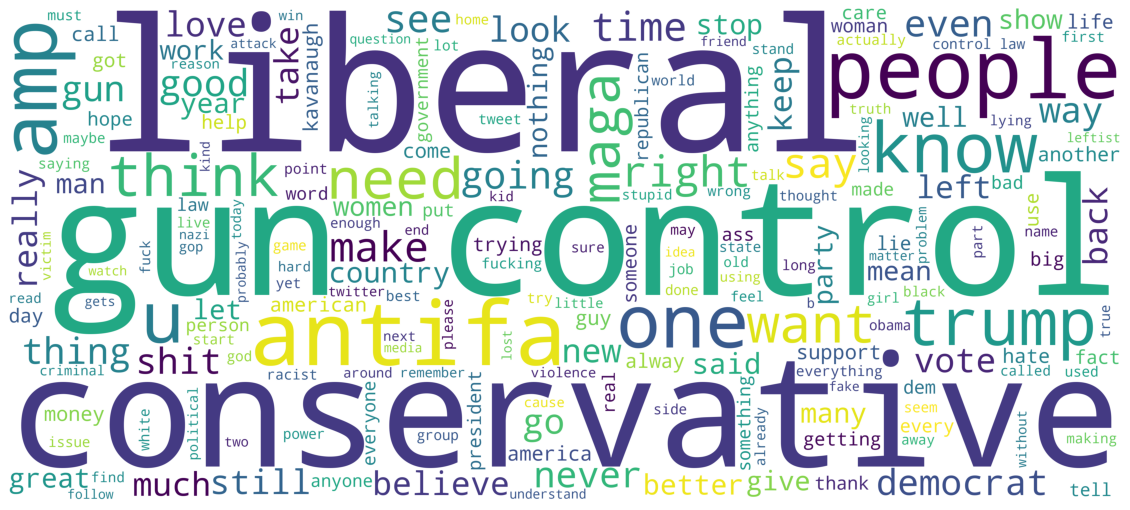

In [9]:
Lewy = list(data['cleaned_tweets'])
sentences = ''
for i in Lewy:
    sentences = sentences + i
wordcloud = WordCloud(
        background_color="white", 
        width=4500,              
        height=2000,              
        margin=10              
        ).generate(sentences)
plt.figure("Accuracy Plot", figsize=(20,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
wordcloud.to_file('semeval2019_worldcloud.png')

### 2.2 Data pre-processing for weka

In [10]:
data2 = pd.read_csv(train_directory, sep='\t', header=0)
update_Data2 = updat_data(data2)
remove_data2 = remove_stopwords(update_Data2)
data2.insert(loc=2, column='cleaned_tweets', value=remove_data2)
data2 = data2.drop(['tweet'],axis = 1)
INDEX2 = []
for i, row in data2.iterrows():
    if(row['cleaned_tweets'] == None or row['cleaned_tweets']==''):
        INDEX2.append(i)
data2.drop(INDEX2,inplace = True)
data2

,id,cleaned_tweets,subtask_a,subtask_b,subtask_c
0,86426,ask native americans take,OFF,UNT,NaN
1,90194,go home drunk maga trump,OFF,TIN,IND
2,16820,amazon investigating chinese employees selling internal data third party sellers looking edge competitive marketplace amazon maga kag china tcot,NOT,NaN,NaN
3,62688,someone taken piece shit volcano,OFF,UNT,NaN
4,43605,obama wanted liberals amp illegals move red states,NOT,NaN,NaN
...,...,...,...,...,...
13235,95338,sometimes get strong vibes people man vibe tens millions murders dangerous dt,OFF,TIN,IND
13236,67210,benidorm creamfields maga shabby summer,NOT,NaN,NaN
13237,82921,report garbage give crap,OFF,TIN,OTH
13238,27429,pussy,OFF,UNT,NaN


In [11]:
def train_pro(filename1,filename2):
    fo=open(filename2,'w',encoding='UTF-8')
    csv_file = csv.reader(open(filename1, 'r', encoding='UTF-8'))
    count1=0
    lewy ={}
    count = 0
    t=0
    a=0
    s=0
    for row in csv_file:
        #print(count)
        count1=0
        if(s==0):
            fo.write(row[0]+","+row[1]+"\n")
            s=s+1
        else:
            list2=[]
            for i in range(len(row[1])):
                if row[1][i] == '"':
                    list2.insert(count,i)
                    count1 = count1+1
                    #print(count1)
            x=len(row[1])
            list1=list(row[1])
            #print(list1)
            list1.insert( 0, '"')
            list1.insert( x+1, '"')
            q=1
            #print(len(list2))
            if(len(list2)!=0):
                for m in range(0,count1):  
                    print(list2[m])
                    list1.insert( list2[m]+q, '\\')
                    q=q+1
            s="".join(list1) 
            for i in range(len(row)):
                if(i!=1):
                    if row[i] == "":
                        row[i] = '?'
            #print(row[0]+","+s+","+row[2]+","+row[3]+","+row[4]+"\n")
            fo.write(row[0]+","+s+","+row[2]+","+row[3]+","+row[4]+"\n") 
            count=count+1
    fo.close()

In [12]:
data2.to_csv('olid_data_1.csv', index=False)

In [13]:
train_pro('olid_data_1.csv','olid_data_1.txt' )

### 3 Experiments
__Note:__ For the deep learning models, in the experiments and testing, the output of each time might be different, in the project report I recorded the best performance for each deep learning model.

#### 3.1 Sub-Task A    __'OFF': 1 'NOT': 0__

In [55]:
A_data = data.drop(['subtask_b'],axis = 1).drop(['subtask_c'],axis = 1)

In [56]:
A_label_index = []
for i, row in data.iterrows():
    if row['subtask_a'] == 'OFF':
        A_label_index.append(1)
    else:
        A_label_index.append(0)

In [57]:
A_data.insert(loc=2, column='labels', value=A_label_index)
A_data = A_data.drop(['subtask_a'],axis = 1)
A_data

,id,cleaned_tweets,labels
0,86426,ask native americans take,1
1,90194,go home drunk maga trump,1
2,16820,amazon investigating chinese employees selling internal data third party sellers looking edge competitive marketplace amazon maga kag china tcot,0
3,62688,someone taken piece shit volcano,1
4,43605,obama wanted liberals amp illegals move red states,0
...,...,...,...
13235,95338,sometimes get strong vibes people man vibe tens millions murders dangerous dt,1
13236,67210,benidorm creamfields maga shabby summer,0
13237,82921,report garbage give crap,1
13238,27429,pussy,1


In [58]:
feature_a = A_data.cleaned_tweets
class_a = A_data.labels
X_train_a, X_test_a, Y_train_a, Y_test_a = train_test_split(feature_a, class_a, test_size =0.2, random_state=1)

In [59]:
def build_tfidf(X_train):    
    cv_b = CountVectorizer()
    X_train_c = cv_b.fit_transform(X_train)
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf_matrix = tfidf_transformer.fit_transform(X_train_c)
    return X_train_tfidf_matrix,cv_b

In [60]:
X_train_tfidf_matrix_a,cv_a = build_tfidf(X_train_a)
X_train_tfidf_matrix_a.shape

(10532, 16330)

#### 3.1.1 Sub-Task A classic machine learning classifiers 

__Logistic Regression Model__

In [139]:
def LR(X_train_tfidf_matrix,Y_train,X_test, Y_test,cv):
    lr_clf = LogisticRegression(C=1).fit(X_train_tfidf_matrix, Y_train)
    # make prediction and print accuracy
    lr_prediction = lr_clf.predict(cv.transform(X_test))
    print(f"Accuracy score is {accuracy_score(Y_test, lr_prediction):.4f}")
    print(classification_report(Y_test, lr_prediction, zero_division = 1,digits=4))

In [21]:
LR(X_train_tfidf_matrix_a,Y_train_a,X_test_a,Y_test_a,cv_a)

Accuracy score is 0.7327
              precision    recall  f1-score   support

           0     0.8199    0.7612    0.7895      1734
           1     0.5957    0.6778    0.6341       900

    accuracy                         0.7327      2634
   macro avg     0.7078    0.7195    0.7118      2634
weighted avg     0.7433    0.7327    0.7364      2634



__SVM__

In [22]:
def SVM(X_train,Y_train,X_test,Y_test):
    pipe = make_pipeline(CountVectorizer(),
                     TfidfTransformer(),
                     SVC())
    param_grid = {'svc__kernel': ['linear']}

    svc_model = GridSearchCV(pipe, param_grid, cv=2, verbose=0)
    svc_model.fit(X_train, Y_train)

    prediction = svc_model.predict(X_test)
    print(f"Accuracy score is {accuracy_score(Y_test, prediction):.4f}")
    print(classification_report(Y_test, prediction,digits = 4))

In [23]:
SVM(X_train_a,Y_train_a,X_test_a,Y_test_a)

Accuracy score is 0.7737
              precision    recall  f1-score   support

           0     0.7704    0.9348    0.8447      1734
           1     0.7868    0.4633    0.5832       900

    accuracy                         0.7737      2634
   macro avg     0.7786    0.6991    0.7140      2634
weighted avg     0.7760    0.7737    0.7554      2634



#### 3.1.2 Task A deep learning classifiers

In [70]:
def draw_graph(model):
    acc = model.history.history['accuracy']
    val_acc = model.history.history['val_accuracy']
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    fig, ax1 = plt.subplots()
    plt.plot(loss, 'r', label = 'train loss', )
    plt.plot(val_loss, 'g', label = 'validation loss' )
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    #plt.title('Training and test loss, and test accuracy')
    ax2=ax1.twinx()
    ax2.plot(acc, 'm', label = 'training accuracy')
    ax2.plot(val_acc, 'b', label = 'validation accuracy')
    ax2.set_ylabel('accuracy')
    plt.legend(loc='upper right')
    #fig.savefig(name)
    plt.show()

In [71]:
def Tokenize(Data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(Data.cleaned_tweets)
    T_sequences = tokenizer.texts_to_sequences(Data.cleaned_tweets)
    T_seq = pad_sequences(T_sequences)
    T_max_seq = T_seq.shape[1]
    print("the word deminson for this sub-task is:", T_max_seq)
    return tokenizer,T_seq,T_max_seq

In [72]:
tokenizer_a,A_seq,A_max_seq = Tokenize(A_data)

the word deminson for this sub-task is: 42


In [73]:
A_classes = A_data.labels
X_train_a, X_test_a, Y_train_a, Y_test_a = train_test_split(A_seq, A_classes, test_size =0.2, random_state=100)

In [74]:
A_sentences =[]
for i in list(A_data['cleaned_tweets']):
    A_sentences.append(i.split())

In [75]:
EMBEDDING_SIZE = 100
model = FastText(A_sentences, vector_size=EMBEDDING_SIZE, window=5, min_count=1, workers=4, epochs = 40)
vocabulary_size_a = len(tokenizer_a.word_index)
print(vocabulary_size_a)

18413


In [76]:
def cons_emdmatrix(tokenizer,vocabulary_size,EMBEDDING_SIZE):
    embedding_matrix = np.zeros((vocabulary_size+1, EMBEDDING_SIZE))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model.wv.get_vector(word) 
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        except KeyError:
            print(word)
    return embedding_matrix

In [77]:
embedding_matrix_a =  cons_emdmatrix(tokenizer_a,vocabulary_size_a,EMBEDDING_SIZE)

__CNN__

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 42)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 42, 100)           1841400   
_________________________________________________________________
dropout_3 (Dropout)          (None, 42, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 39, 64)            25664     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 16)               

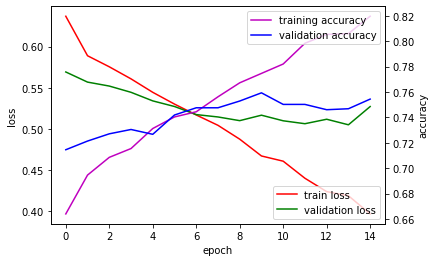

Accuracy score is  0.7544
              precision    recall  f1-score   support

         OFF     0.7803    0.8896    0.8314      1793
         NOT     0.6644    0.4661    0.5479       841

    accuracy                         0.7544      2634
   macro avg     0.7224    0.6778    0.6896      2634
weighted avg     0.7433    0.7544    0.7409      2634



In [37]:
inp = Input(shape = (A_max_seq,))

model = Embedding(vocabulary_size_a+1, EMBEDDING_SIZE, weights = [embedding_matrix_a], input_length=A_max_seq, trainable = True)(inp)
model = Dropout(0.6)(model)
model = Conv1D(64, 4, activation='relu')(model)
model = GlobalMaxPooling1D()(model)
model = Dense(32, activation = 'relu')(model)
model = Dense(16, activation = 'relu')(model)
out_a = Dense(1, activation = 'sigmoid')(model)

model_conv_a = Model(inputs = inp, outputs = out_a)
model_conv_a.compile(loss = "binary_crossentropy", optimizer= Adam(lr= 0.001), metrics=["accuracy"] )
model_conv_a.summary()

model_conv_a.fit(X_train_a, Y_train_a, validation_data=(X_test_a,Y_test_a), epochs = 15)

draw_graph(model_conv_a)

y_pred_a = model_conv_a.predict(X_test_a)
y_pred_a = y_pred_a>0.5
cnn_accuracy_A = accuracy_score(Y_test_a, y_pred_a)
print("Accuracy score is ", round(cnn_accuracy_A ,4) )
print(classification_report(Y_test_a, y_pred_a, target_names= ["OFF",'NOT'],digits=4))

__RNN Networks__

In [80]:
def taska_RNN_net(Network):
    inp = Input(shape = (A_max_seq,))
    model = Embedding(vocabulary_size_a+1, EMBEDDING_SIZE, weights = [embedding_matrix_a], trainable = True)(inp)
    if Network == 'LSTM':
        model = LSTM(32, dropout=0.5, recurrent_dropout=0, return_sequences=True)(model)
    elif Network == 'GRU':
        model = GRU(32, dropout=0.5, recurrent_dropout=0, return_sequences=True)(model)
    else:
        model = Bidirectional( LSTM(32, dropout=0.5, recurrent_dropout=0, return_sequences=True))(model)
    model = GlobalMaxPooling1D()(model)
    model = Dense(64, activation = "relu")(model)
    model = Dropout(0.5)(model)
    model = Dense(32, activation = "relu")(model)
    model = Dropout(0.5)(model)
    out_a = Dense(1, activation = "sigmoid")(model)


    model_rnns = Model(inputs = inp, outputs = out_a)
    model_rnns.compile( loss = "binary_crossentropy", optimizer = Adam(lr=0.001), metrics = ["accuracy"])
    model_rnns.summary()
    model_rnns.fit(X_train_a, Y_train_a, validation_data=(X_test_a,Y_test_a), epochs = 7)

    draw_graph(model_rnns)
    
    y_pred_rnns = model_rnns.predict(X_test_a)
    y_pred_rnns = y_pred_rnns>0.5
    
    rnns_accuracy_A = accuracy_score(Y_test_a, y_pred_rnns)
    print("Accuracy score is ", round(cnn_accuracy_A ,4) )
    print(classification_report(Y_test_a, y_pred_rnns,target_names= ["OFF",'NOT'],digits = 4))

 This part just shows the output of GRU network for sub-task A, if you want to run another models,just change the comments

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 42)]              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 42, 100)           1841400   
_________________________________________________________________
gru_3 (GRU)                  (None, 42, 32)            12864     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)              

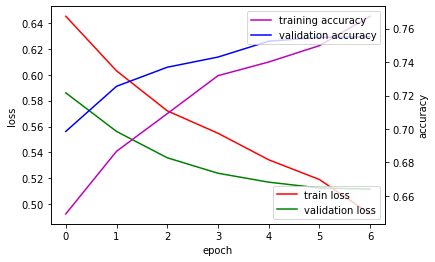

Accuracy score is  0.7544
              precision    recall  f1-score   support

         OFF     0.7697    0.9136    0.8355      1793
         NOT     0.6937    0.4174    0.5212       841

    accuracy                         0.7551      2634
   macro avg     0.7317    0.6655    0.6783      2634
weighted avg     0.7455    0.7551    0.7351      2634



In [81]:
taska_RNN_net('GRU')
#taska_RNN_net('LSTM')
#taska_RNN_net('BILSTM')

#### 3.2 Sub-Task B __TIN:0 UNT:1__

In [107]:
B_data = data[data['subtask_a']== 'OFF'].drop(['subtask_a'],axis = 1).drop(['subtask_c'],axis = 1)
B_label_index = []
for i, row in B_data.iterrows():
    if row['subtask_b'] == 'TIN':
        B_label_index.append(1)
    else:
        B_label_index.append(0)
B_data.insert(loc=2, column='labels', value=B_label_index)
B_data = B_data.drop(['subtask_b'],axis = 1)
B_data

,id,cleaned_tweets,labels
0,86426,ask native americans take,0
1,90194,go home drunk maga trump,1
3,62688,someone taken piece shit volcano,0
5,97670,liberals kookoo,1
6,77444,oh noes tough shit,0
...,...,...,...
13223,63482,advocating conduct within bounds human rights terrorists categorized human kill people mostly innocent like berserk wild beasts even wild beasts kill hungry feel indian army greatly,1
13227,87416,liars like antifa twins vigorously defend,1
13235,95338,sometimes get strong vibes people man vibe tens millions murders dangerous dt,1
13237,82921,report garbage give crap,1


####  3.2.1 Task B classic machine learning classifiers

In [108]:
feature_b = B_data.cleaned_tweets
class_b = B_data.labels
X_train_b, X_test_b, Y_train_b, Y_test_b= train_test_split(feature_b, class_b, test_size =0.2, random_state=100)

In [109]:
X_train_tfidf_matrix_b,cv_b = build_tfidf(X_train_b)
X_train_tfidf_matrix_b.shape

(3516, 8710)

In [86]:
LR(X_train_tfidf_matrix_b,Y_train_b,X_test_b,Y_test_b,cv_b)

Accuracy score is 0.8330
              precision    recall  f1-score   support

           0     0.2000    0.1471    0.1695       102
           1     0.8919    0.9229    0.9071       778

    accuracy                         0.8330       880
   macro avg     0.5460    0.5350    0.5383       880
weighted avg     0.8117    0.8330    0.8216       880



In [87]:
SVM(X_train_b,Y_train_b,X_test_b,Y_test_b)

Accuracy score is 0.8807
              precision    recall  f1-score   support

           0     0.2000    0.0098    0.0187       102
           1     0.8846    0.9949    0.9365       778

    accuracy                         0.8807       880
   macro avg     0.5423    0.5023    0.4776       880
weighted avg     0.8052    0.8807    0.8301       880



#### 3.2.2  Task B deep learning models

In [112]:
tokenizer_b,B_seq,B_max_seq = Tokenize(B_data)

the word deminson for this sub-task is: 35


In [113]:
B_classes = B_data.labels
X_train_b, X_test_b, Y_train_b, Y_test_b = train_test_split(B_seq, B_classes, test_size =0.2, random_state=100)

In [114]:
B_sentences =[]
for i in list(B_data['cleaned_tweets']):
    B_sentences.append(i.split())

In [115]:
EMBEDDING_SIZE = 100
model = FastText(B_sentences, vector_size=EMBEDDING_SIZE, window=5, min_count=1, workers=4, epochs = 40)
vocabulary_size_b = len(tokenizer_b.word_index)
print(vocabulary_size_b)

9914


In [116]:
embedding_matrix_b =  cons_emdmatrix(tokenizer_b,vocabulary_size_b,EMBEDDING_SIZE)

__CNN__

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 35)]              0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 35, 100)           991500    
_________________________________________________________________
dropout_14 (Dropout)         (None, 35, 100)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 32, 64)            25664     
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_31 (Dense)             (None, 16)              

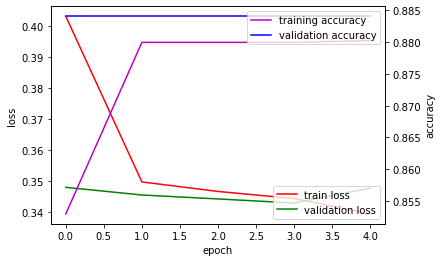

Accuracy score is 0.8841
              precision    recall  f1-score   support

         TIN     0.0000    0.0000    0.0000       102
         UTI     0.8841    1.0000    0.9385       778

    accuracy                         0.8841       880
   macro avg     0.4420    0.5000    0.4692       880
weighted avg     0.7816    0.8841    0.8297       880



In [100]:
inp = Input(shape = (B_max_seq,))

model = Embedding(vocabulary_size_b+1, EMBEDDING_SIZE, weights = [embedding_matrix_b], input_length=B_max_seq, trainable = True)(inp)
model = Dropout(0.2)(model)
model = Conv1D(64, 4, activation='relu')(model)
model = GlobalMaxPooling1D()(model)
model = Dense(32, activation = 'relu')(model)
model = Dense(16, activation = 'relu')(model)
out_b = Dense(1, activation = 'sigmoid')(model)

b_model_conv_b = Model(inputs = inp, outputs = out_b)
b_model_conv_b.compile(loss = "binary_crossentropy", optimizer=Adam(lr = 0.00015), metrics=["accuracy"] )
b_model_conv_b.summary()
b_model_conv_b.fit(X_train_b, Y_train_b, validation_data=(X_test_b,Y_test_b), epochs = 5)
draw_graph(b_model_conv_b)

y_pred_b = b_model_conv_b.predict(X_test_b)
y_pred_b = y_pred_b>0.5
cnn_accuracy_B = accuracy_score(Y_test_b, y_pred_b)
print("Accuracy score is ", round(cnn_accuracy_B ,4) )
print(classification_report(Y_test_b, y_pred_b, target_names= ["TIN",'UTI'],digits = 4))

__RNN Networks__

In [132]:
def taskb_RNN_net(Network):
    model = Embedding(vocabulary_size_b+1, EMBEDDING_SIZE, weights = [embedding_matrix_b], trainable = True)(inp)

    if Network == 'LSTM':
        model = LSTM(32, dropout=0.5, recurrent_dropout=0, return_sequences=True)(model)
    elif Network == 'GRU':
        model = GRU(32, dropout=0.5, recurrent_dropout=0, return_sequences=True)(model)
    else:
        model = Bidirectional( LSTM(32, dropout=0.5, recurrent_dropout=0, return_sequences=True))(model)

    model = GlobalMaxPooling1D()(model)

    model = Dense(64, activation = "relu")(model)
    model = Dropout(0.5)(model)
    model = Dense(32, activation = "relu")(model)
    model = Dropout(0.5)(model)
    out_b = Dense(1, activation = "sigmoid")(model)


    b_model_rnns = Model(inputs = inp, outputs = out_b)
    b_model_rnns.compile( loss = "binary_crossentropy", optimizer = Adam(lr=0.1), metrics = ["accuracy"])
    b_model_rnns.summary()
    b_model_rnns.fit(X_train_b, Y_train_b, validation_data=(X_test_b,Y_test_b), epochs = 5)

    draw_graph(b_model_rnns)

    y_pred_rnns = b_model_rnns.predict(X_test_b)
    y_pred_rnns = y_pred_rnns>0.5
    cnn_accuracy_B = accuracy_score(Y_test_b,y_pred_rnns)
    print("Accuracy score is ", round(cnn_accuracy_B ,4) )
    print(classification_report(Y_test_b, y_pred_rnns,target_names= ["OFF",'NOT'],digits = 4,zero_division=1))

Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 35)]              0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 35, 100)           991500    
_________________________________________________________________
lstm_6 (LSTM)                (None, 35, 32)            17024     
_________________________________________________________________
global_max_pooling1d_17 (Glo (None, 32)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 32)              

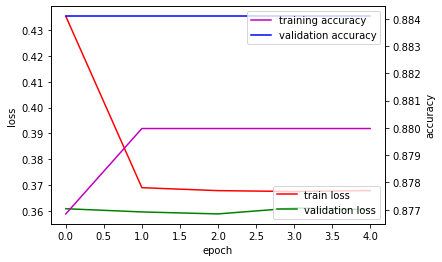

Accuracy score is  0.8841
              precision    recall  f1-score   support

         OFF     1.0000    0.0000    0.0000       102
         NOT     0.8841    1.0000    0.9385       778

    accuracy                         0.8841       880
   macro avg     0.9420    0.5000    0.4692       880
weighted avg     0.8975    0.8841    0.8297       880



In [133]:
taskb_RNN_net('LSTM')
#taskb_RNN_net('GRU')
#taskb_RNN_net('BILSTM')

#### 3.3 Sub-Task C  

In [121]:
C_data = data[data['subtask_b']== 'TIN'].drop(['subtask_a'],axis = 1).drop(['subtask_b'],axis = 1)
C_label_index = []
for i, row in C_data.iterrows():
    if row['subtask_c'] == 'IND':
        C_label_index.append(1)
    elif row['subtask_c'] == 'OTH' :
        C_label_index.append(2)
    else:
        C_label_index.append(0)
C_data.insert(loc=2, column='labels', value=C_label_index)
C_data = C_data.drop(['subtask_c'],axis = 1)

####  3.3.1 Task C classic machine learning classifiers

In [161]:
feature_c = C_data.cleaned_tweets
class_c = C_data.labels
X_train_c, X_test_c, Y_train_c, Y_test_c= train_test_split(feature_c, class_c, test_size =.2, random_state=100)

In [162]:
X_train_tfidf_matrix_c,cv_c = build_tfidf(X_train_c)
X_train_tfidf_matrix_c.shape

(3097, 8201)

In [141]:
LR(X_train_tfidf_matrix_c,Y_train_c,X_test_c,Y_test_c,cv_c)

Accuracy score is 0.5884
              precision    recall  f1-score   support

           0     0.3906    0.7382    0.5109       191
           1     0.8204    0.6120    0.7010       500
           2     0.2195    0.1071    0.1440        84

    accuracy                         0.5884       775
   macro avg     0.4768    0.4858    0.4520       775
weighted avg     0.6493    0.5884    0.5938       775



In [142]:
SVM(X_train_c,Y_train_c,X_test_c,Y_test_c)

Accuracy score is 0.6942
              precision    recall  f1-score   support

           0     0.5307    0.4974    0.5135       191
           1     0.7454    0.8840    0.8088       500
           2     0.3333    0.0119    0.0230        84

    accuracy                         0.6942       775
   macro avg     0.5365    0.4644    0.4484       775
weighted avg     0.6478    0.6942    0.6508       775



####  3.3.2 Task C deep learning models

In [170]:
tokenizer_c,C_seq,C_max_seq = Tokenize(C_data)

the word deminson for this sub-task is: 35


In [171]:
C_classes = C_data.labels
X_train_c, X_test_c, Y_train_c, Y_test_c = train_test_split(C_seq, C_classes, test_size =0.2, random_state=100)

In [172]:
C_sentences =[]
for i in list(C_data['cleaned_tweets']):
    C_sentences.append(i.split())

In [173]:
EMBEDDING_SIZE = 100
model = FastText(C_sentences, vector_size=EMBEDDING_SIZE, window=5, min_count=1, workers=4, epochs = 40)
vocabulary_size_c = len(tokenizer_c.word_index)
print(vocabulary_size_c)

9277


In [174]:
embedding_matrix_c =  cons_emdmatrix(tokenizer_c,vocabulary_size_c,EMBEDDING_SIZE)
HD = np_utils.to_categorical(Y_train_c)
QT = np_utils.to_categorical(Y_test_c)

__CNN__

Model: "functional_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 35)]              0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 35, 100)           927800    
_________________________________________________________________
dropout_32 (Dropout)         (None, 35, 100)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 32, 64)            25664     
_________________________________________________________________
global_max_pooling1d_21 (Glo (None, 64)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_61 (Dense)             (None, 3)               

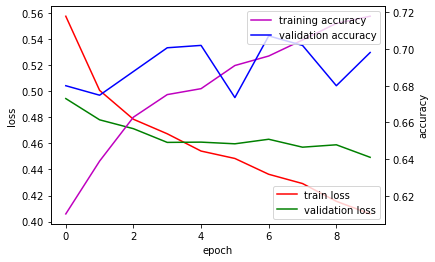

Accuracy score is: 0.6981
              precision    recall  f1-score   support

         IND     0.5642    0.5288    0.5459       191
         OTH     0.7383    0.8800    0.8029       500
         GRP     1.0000    0.0000    0.0000        84

    accuracy                         0.6981       775
   macro avg     0.7675    0.4696    0.4496       775
weighted avg     0.7237    0.6981    0.6526       775



In [151]:
inp = Input(shape =(C_max_seq,))


model = Embedding(vocabulary_size_c+1, EMBEDDING_SIZE, weights = [embedding_matrix_c], input_length=C_max_seq, trainable = True)(inp)
model = Dropout(0.58)(model)
model = Conv1D(64, 4, activation='relu')(model)
model = GlobalMaxPooling1D()(model)
model = Dense(32, activation = 'relu')(model)

out_c = Dense(3, activation = 'sigmoid')(model)

model_conv_c = Model(inputs = inp, outputs = out_c)
model_conv_c.compile(loss = "binary_crossentropy", optimizer=Adam(lr= 0.001), metrics=["accuracy"] )
model_conv_c.summary()

model_conv_c.fit(np.array(X_train_c), HD, validation_data=(X_test_c,QT), epochs = 10)

draw_graph(model_conv_c)
y_pred_c = model_conv_c.predict(X_test_c)
y_pred_c = np.argmax(y_pred_c,axis=1)
Accuracy_testc = accuracy_score(Y_test_c, y_pred_c)
print("Accuracy score is:",round(Accuracy_testc,4))
print(classification_report(Y_test_c, y_pred_c, target_names= ["IND",'OTH', "GRP"], zero_division = 1,digits=4))

__RNN Networks__

In [168]:
def taskc_RNN_net(Network):
    inp = Input(shape = (C_max_seq,))

    model = Embedding(vocabulary_size_c+1, EMBEDDING_SIZE, weights = [embedding_matrix_c], trainable = True)(inp)
    model = Dropout(0.5)(model)
    if Network == 'LSTM':
        model = LSTM(32, dropout=0.5, recurrent_dropout=0, return_sequences=True)(model)
    elif Network == 'GRU':
        model = GRU(32, dropout=0.5, recurrent_dropout=0, return_sequences=True)(model)
    else:
        model = Bidirectional( LSTM(32, dropout=0.5, recurrent_dropout=0, return_sequences=True))(model)
    avg_pool = GlobalAveragePooling1D()(model)
    max_pool = GlobalMaxPooling1D()(model)
    model = concatenate([avg_pool, max_pool])
    model = Dense(64, activation = "relu")(model)
    model = Dropout(0.5)(model)

    out_c = Dense(3, activation = "softmax")(model)

    model_c = Model(inputs = inp, outputs = out_c)

    model_c.compile( loss = "binary_crossentropy", optimizer = Adam(lr=0.001), metrics = ["accuracy"])
    model_c.summary()

    model_c.fit(np.array(X_train_c), HD, validation_data=(X_test_c,QT), epochs = 5)

    draw_graph(model_c)

    y_pred_c = model_c.predict(X_test_c)
    y_pred_c = np.argmax(y_pred_c,axis=1)
    Accuracy_testc = accuracy_score(Y_test_c, y_pred_c)
    print("Accuracy score is:",round(Accuracy_testc,4))
    print(classification_report(Y_test_c, y_pred_c, target_names= ["IND",'OTH', "GRP"],digits = 4))

Model: "functional_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 35)]         0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 35, 100)      927800      input_17[0][0]                   
__________________________________________________________________________________________________
dropout_35 (Dropout)            (None, 35, 100)      0           embedding_23[0][0]               
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 35, 32)       17024       dropout_35[0][0]                 
______________________________________________________________________________________

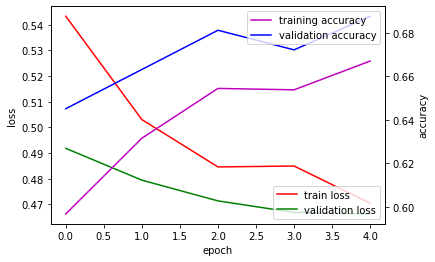

Accuracy score is: 0.6877
              precision    recall  f1-score   support

         IND     0.5662    0.4031    0.4709       191
         OTH     0.7136    0.9120    0.8007       500
         GRP     0.0000    0.0000    0.0000        84

    accuracy                         0.6877       775
   macro avg     0.4266    0.4384    0.4239       775
weighted avg     0.5999    0.6877    0.6326       775



In [175]:
taskc_RNN_net('LSTM')
#taskc_RNN_net('LSTM')
#taskc_RNN_net('LSTM')

### 4 Testing

In [38]:
test_a_f ="C:/Users/93585/Desktop/MSC_project/report/DATASET/OLID/testset-levela.tsv"
test_b_f ="C:/Users/93585/Desktop/MSC_project/report/DATASET/OLID/testset-levelb.tsv"
test_c_f ="C:/Users/93585/Desktop/MSC_project/report/DATASET/OLID/testset-levelc.tsv"

test_a_l ="C:/Users/93585/Desktop/MSC_project/report/DATASET/OLID/labels-levela.csv"
test_b_l ="C:/Users/93585/Desktop/MSC_project/report/DATASET/OLID/labels-levelb.csv"
test_c_l ="C:/Users/93585/Desktop/MSC_project/report/DATASET/OLID/labels-levelc.csv"

test_a  = pd.read_csv(test_a_f, sep='\t', header=0)
test_b  = pd.read_csv(test_b_f, sep='\t', header=0)
test_c  = pd.read_csv(test_c_f, sep='\t', header=0)

In [39]:
def Read_labels(file):
    with open(file,mode='rt',encoding='utf8' ) as f:
        reader = csv.reader(f)
        labels = []
        for item in reader:
            labels.append(item[1])
    return labels

In [40]:
def Get_acc(orig_label,rel_label):
    T = len(orig_label)
    Cor = 0 
    for i in range(T):
        if orig_label[i] == rel_label[i]:

            Cor = Cor+1
    print(round(Cor/T,3))

The following codes of three sub-tasks just shows the testing process of CNN model and SVM, if you want to test other models just re-run the model you want in last section and replace corresponding model name in this part.

#### 4.1 Sub-Task A  Sub-Task A    __'OFF': 1 'NOT': 0__

In [41]:
update_Data = updat_data(test_a)
remove_data = remove_stopwords(update_Data)
test_a.insert(loc=2, column='cleaned_tweets', value=remove_data)
test_a = test_a.drop(['tweet'],axis = 1)

In [44]:
sequences = tokenizer_a.texts_to_sequences(test_a["cleaned_tweets"])
seq_testa = pad_sequences(sequences, maxlen = A_max_seq)

In [45]:
predict = model_conv_a.predict(seq_testa)
T= predict>0.5

In [46]:
def classify_a(predict_arr,threshold):
    prediction = []
    for i in predict_arr:
        if(i[0]<= threshold):
            prediction.append('NOT')
        else:
            prediction.append('OFF')
    return prediction

In [47]:
prediction = classify_a(predict,0.5)

In [48]:
real_test_label = Read_labels(test_a_l)

In [49]:
A_test_index = []
for i in real_test_label:
    if i == 'OFF':
        A_test_index.append(1)
    else:
        A_test_index.append(0)

In [50]:
Get_acc(prediction,real_test_label)
print(classification_report(A_test_index, T, target_names= ["OFF",'NOT'],digits=4))

0.801
              precision    recall  f1-score   support

         OFF     0.8316    0.9081    0.8682       620
         NOT     0.6885    0.5250    0.5957       240

    accuracy                         0.8012       860
   macro avg     0.7601    0.7165    0.7320       860
weighted avg     0.7917    0.8012    0.7921       860



In [63]:
prediction_svm = svc_model.predict(test_a.cleaned_tweets)
accuracy_testa = accuracy_score(A_test_index, prediction_svm)
print("Accuracy score is:", round(accuracy_testa,4))
print(classification_report(A_test_index, prediction_svm,digits = 4))

Accuracy score is: 0.8209
              precision    recall  f1-score   support

           0     0.8183    0.9661    0.8861       620
           1     0.8359    0.4458    0.5815       240

    accuracy                         0.8209       860
   macro avg     0.8271    0.7060    0.7338       860
weighted avg     0.8232    0.8209    0.8011       860



#### 4.2 Sub-Task B TIN': 1 'UNT': 0

In [101]:
update_Data = updat_data(test_b)
remove_data = remove_stopwords(update_Data)
test_b.insert(loc=2, column='cleaned_tweets', value=remove_data)
test_b = test_b.drop(['tweet'],axis = 1)

In [102]:
sequencesb = tokenizer_b.texts_to_sequences(test_b["cleaned_tweets"])
seq_testb = pad_sequences(sequencesb, maxlen = B_max_seq)

In [103]:
def classify_b(predict_arr,threshold):
    prediction = []
    for i in predict_arr:
        if(i[0]<= threshold):
            prediction.append('UNT')
        else:
            prediction.append('TIN')
    return prediction

In [104]:
predict_b = b_model_conv_b.predict(seq_testb)
T = predict_b > 0.5
prediction_b = classify_b(predict_b,0.5)
b_real_test_label = Read_labels(test_b_l)

In [105]:
B_test_index = []
for i in b_real_test_label:
    if i == 'TIN':
        B_test_index.append(1)
    else:
        B_test_index.append(0)

In [106]:
Get_acc(prediction_b,b_real_test_label)
print(classification_report(B_test_index, T, target_names= ["OFF",'NOT'],digits=4))

0.887
              precision    recall  f1-score   support

         OFF     0.0000    0.0000    0.0000        27
         NOT     0.8875    1.0000    0.9404       213

    accuracy                         0.8875       240
   macro avg     0.4437    0.5000    0.4702       240
weighted avg     0.7877    0.8875    0.8346       240



In [111]:
prediction_svm_b = svc_model.predict(test_b.cleaned_tweets)
accuracy_testb = accuracy_score(B_test_index, prediction_svm_b)
print("Accuracy score is:", round(accuracy_testb,4))
print(classification_report(B_test_index, prediction_svm_b,digits = 4))

Accuracy score is: 0.8833
              precision    recall  f1-score   support

           0     0.3333    0.0370    0.0667        27
           1     0.8903    0.9906    0.9378       213

    accuracy                         0.8833       240
   macro avg     0.6118    0.5138    0.5022       240
weighted avg     0.8276    0.8833    0.8398       240



#### 4.3 Sub-Task C  'IND': 1 'OTH': 2 'GRP': 0

In [152]:
update_Data = updat_data(test_c)
remove_data = remove_stopwords(update_Data)
test_c.insert(loc=2, column='cleaned_tweets', value=remove_data)
test_c = test_c.drop(['tweet'],axis = 1)

In [153]:
sequences = tokenizer_c.texts_to_sequences(test_c["cleaned_tweets"])
seq_test_c = pad_sequences(sequences, maxlen = C_max_seq)

In [154]:
predict = model_conv_c.predict(seq_test_c)
predict = np.argmax(predict,axis=1)
prediction_c = []
for i in predict:
    if i == 1:
        prediction_c.append('IND')
    elif i == 2:
        prediction_c.append('OTH')
    else:
        prediction_c.append('GRP')

In [157]:
c_real_test_label = Read_labels(test_c_l)


In [158]:
C_test_index = []
for i in c_real_test_label:
    if i == 'IND':
        C_test_index.append(1)
    elif i == 'OTH':
        C_test_index.append(2)
    else:
        C_test_index.append(0)

In [159]:
Get_acc(prediction_c,c_real_test_label)
print(classification_report(C_test_index,predict , target_names= ["IND",'OTH', "GRP"],digits=4))

0.648
              precision    recall  f1-score   support

         IND     0.6486    0.6154    0.6316        78
         OTH     0.6475    0.9000    0.7531       100
         GRP     0.0000    0.0000    0.0000        35

    accuracy                         0.6479       213
   macro avg     0.4320    0.5051    0.4616       213
weighted avg     0.5415    0.6479    0.5849       213



In [166]:
prediction_svm_c = svc_model.predict(test_c.cleaned_tweets)
accuracy_test_c = accuracy_score(C_test_index, prediction_svm_c)
print("Accuracy score is:" , round(accuracy_test_c,4))
print(classification_report(C_test_index, prediction_svm_c, zero_division=1,digits = 4))

Accuracy score is: 0.6103
              precision    recall  f1-score   support

           0     0.5942    0.5256    0.5578        78
           1     0.6181    0.8900    0.7295       100
           2     1.0000    0.0000    0.0000        35

    accuracy                         0.6103       213
   macro avg     0.7374    0.4719    0.4291       213
weighted avg     0.6721    0.6103    0.5468       213

